In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import tomllib
from pathlib import Path
from pandas import DataFrame
from common.utils import load_dataset, optimize_memory
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib
import os
import xgboost as xgb

## Exploratory Data Analysis

In [2]:
color = sns.color_palette()

#### Training dataframe overview

In [3]:
train_df: DataFrame = load_dataset("loan-approval-prediction-clone", index=False)
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
train_df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [7]:
optimize_memory(train_df, deep=True)

Memory usage of properties dataframe is : 17.76529312133789  MB
******************************
Column:  person_age
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  person_income
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  person_emp_length
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  loan_amnt
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  loan_int_rate
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  loan_percent_income
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  cb_person_cred_hist_length
dtype before:  int64
dtype after:  uint8
******************************
**************************

(       person_age  person_income person_home_ownership  person_emp_length  \
 id                                                                          
 0              37          35000                  RENT                  0   
 1              22          56000                   OWN                  6   
 2              29          28800                   OWN                  8   
 3              30          70000                  RENT                 14   
 4              22          60000                  RENT                  2   
 ...           ...            ...                   ...                ...   
 58640          34         120000              MORTGAGE                  5   
 58641          28          28800                  RENT                  0   
 58642          23          44000                  RENT                  7   
 58643          22          30000                  RENT                  2   
 58644          31          75000              MORTGAGE         

In [8]:
train_df.dtypes

person_age                      uint8
person_income                  uint32
person_home_ownership          object
person_emp_length               uint8
loan_intent                    object
loan_grade                     object
loan_amnt                      uint16
loan_int_rate                 float32
loan_percent_income           float32
cb_person_default_on_file      object
cb_person_cred_hist_length      uint8
loan_status                     uint8
dtype: object

<Axes: xlabel='count', ylabel='person_home_ownership'>

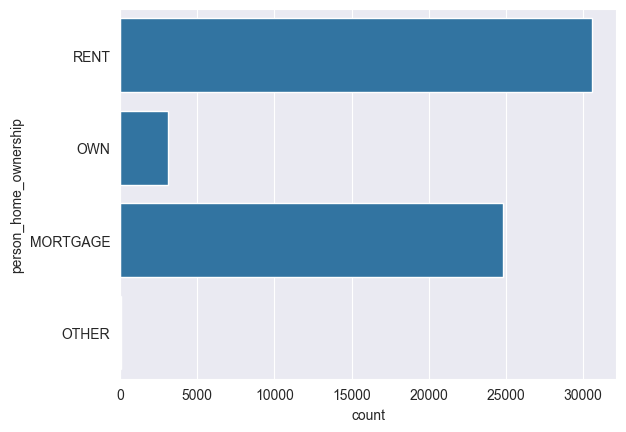

In [9]:
sns.countplot(train_df['person_home_ownership'])

<Axes: xlabel='count', ylabel='loan_intent'>

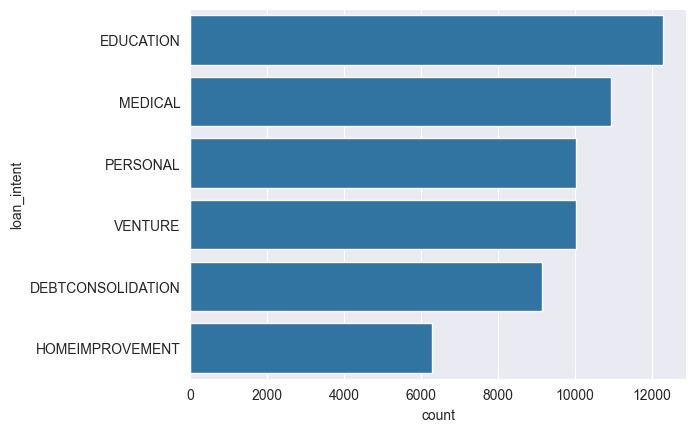

In [10]:
sns.countplot(train_df['loan_intent'])

<Axes: xlabel='count', ylabel='loan_grade'>

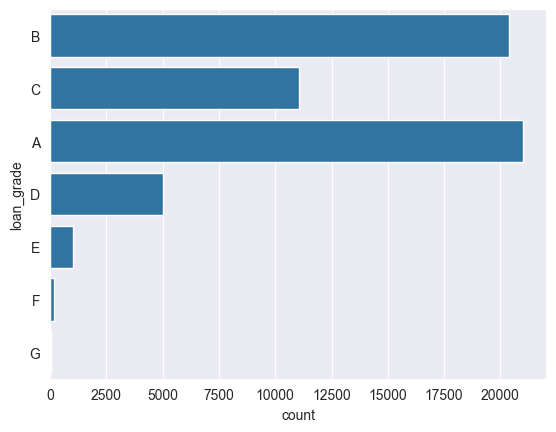

In [11]:
sns.countplot(train_df['loan_grade'])

<Axes: xlabel='count', ylabel='cb_person_default_on_file'>

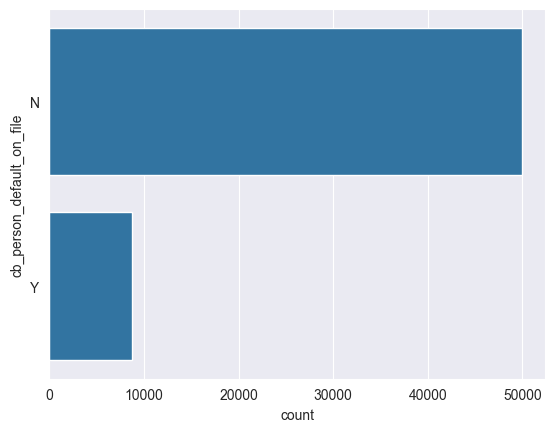

In [12]:
sns.countplot(train_df['cb_person_default_on_file'])

In [13]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade',
                    'cb_person_default_on_file']

train_df = pd.get_dummies(train_df,
                          columns=categorical_cols,
                          drop_first=True)

train_df.columns = [col.lower() for col in train_df.columns]

train_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_other,person_home_ownership_own,...,loan_intent_medical,loan_intent_personal,loan_intent_venture,loan_grade_b,loan_grade_c,loan_grade_d,loan_grade_e,loan_grade_f,loan_grade_g,cb_person_default_on_file_y
id,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0,6000,11.49,0.17,14,0,False,False,...,False,False,False,True,False,False,False,False,False,False
1,22,56000,6,4000,13.35,0.07,2,0,False,True,...,True,False,False,False,True,False,False,False,False,False
2,29,28800,8,6000,8.90,0.21,10,0,False,True,...,False,True,False,False,False,False,False,False,False,False
3,30,70000,14,12000,11.11,0.17,5,0,False,False,...,False,False,True,True,False,False,False,False,False,False
4,22,60000,2,6000,6.92,0.10,3,0,False,False,...,True,False,False,False,False,False,False,False,False,False


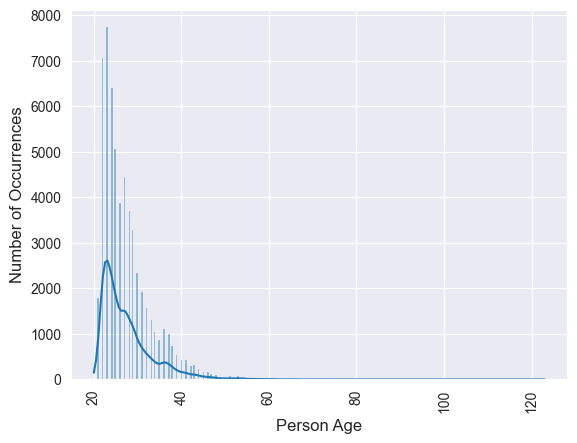

In [14]:
sns.histplot(train_df['person_age'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Age', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

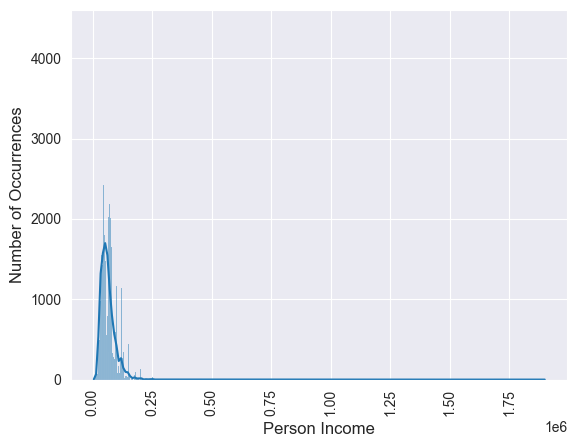

In [15]:
sns.histplot(train_df['person_income'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Income', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

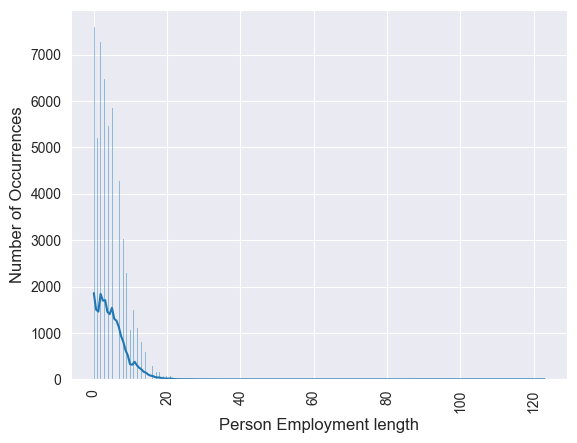

In [16]:
sns.histplot(train_df['person_emp_length'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Employment length', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

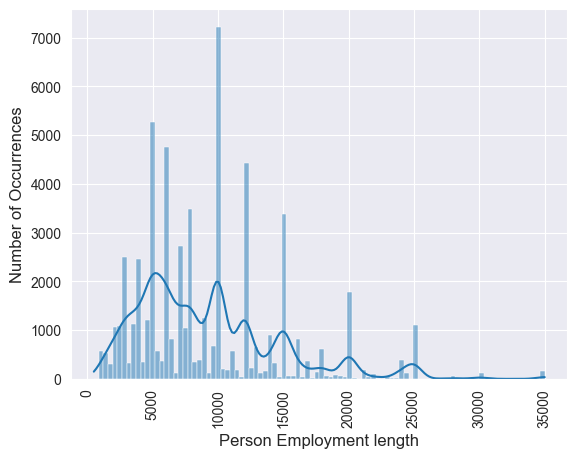

In [17]:
sns.histplot(train_df['loan_amnt'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Employment length', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

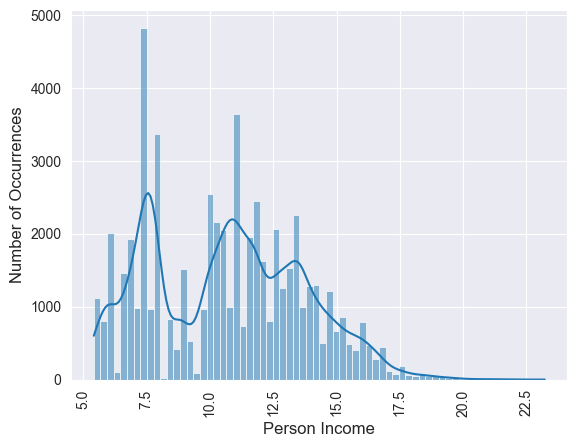

In [18]:
sns.histplot(train_df['loan_int_rate'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Income', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

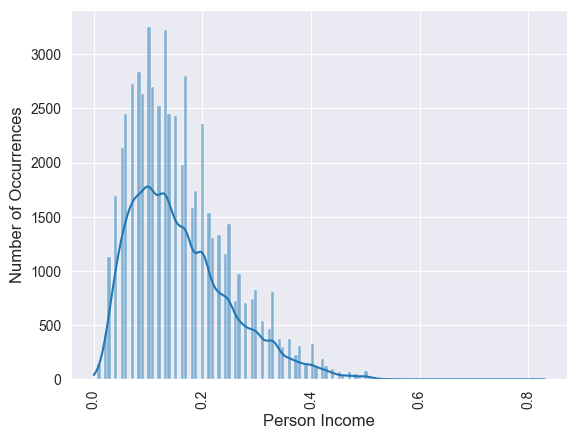

In [19]:
sns.histplot(train_df['loan_percent_income'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Income', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

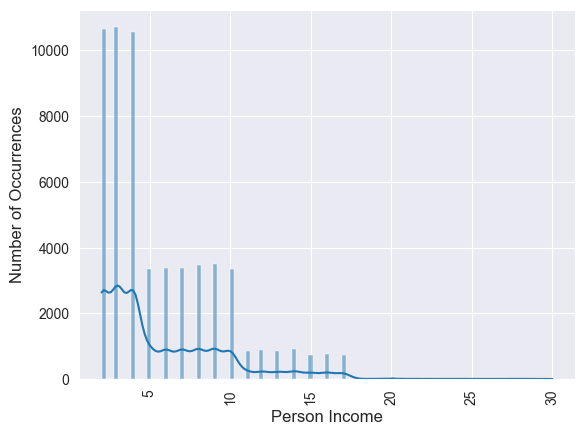

In [20]:
sns.histplot(train_df['cb_person_cred_hist_length'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Income', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

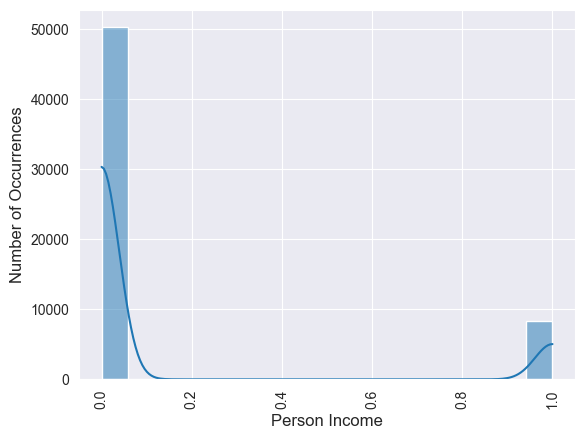

In [21]:
sns.histplot(train_df['loan_status'], kde=True)
plt.xticks(rotation='vertical')
plt.xlabel('Person Income', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [22]:
np.random.seed(42)

In [23]:
print(train_df.isnull().sum())

train_df = train_df.bfill()

X = train_df.drop(columns=['loan_status']) 
y = train_df['loan_status']

X = pd.get_dummies(X)  
X.head()

person_age                     0
person_income                  0
person_emp_length              0
loan_amnt                      0
loan_int_rate                  0
loan_percent_income            0
cb_person_cred_hist_length     0
loan_status                    0
person_home_ownership_other    0
person_home_ownership_own      0
person_home_ownership_rent     0
loan_intent_education          0
loan_intent_homeimprovement    0
loan_intent_medical            0
loan_intent_personal           0
loan_intent_venture            0
loan_grade_b                   0
loan_grade_c                   0
loan_grade_d                   0
loan_grade_e                   0
loan_grade_f                   0
loan_grade_g                   0
cb_person_default_on_file_y    0
dtype: int64


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_other,person_home_ownership_own,person_home_ownership_rent,...,loan_intent_medical,loan_intent_personal,loan_intent_venture,loan_grade_b,loan_grade_c,loan_grade_d,loan_grade_e,loan_grade_f,loan_grade_g,cb_person_default_on_file_y
id,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0,6000,11.49,0.17,14,False,False,True,...,False,False,False,True,False,False,False,False,False,False
1,22,56000,6,4000,13.35,0.07,2,False,True,False,...,True,False,False,False,True,False,False,False,False,False
2,29,28800,8,6000,8.90,0.21,10,False,True,False,...,False,True,False,False,False,False,False,False,False,False
3,30,70000,14,12000,11.11,0.17,5,False,False,True,...,False,False,True,True,False,False,False,False,False,False
4,22,60000,2,6000,6.92,0.10,3,False,False,True,...,True,False,False,False,False,False,False,False,False,False


In [24]:
y.head()

id
0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: uint8

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',   # Binary classification
    'eval_metric': 'logloss',         # Logarithmic loss
    'max_depth': 6,                   # Maximum tree depth
    'eta': 0.5,                       # Learning rate
    'subsample': 0.8,                 # Row sampling
    'colsample_bytree': 0.8,          # Feature sampling
    'seed': 42
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [27]:
# Predict probabilities
y_pred_prob = bst.predict(dtest)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9497


In [28]:
# Save the trained model using joblib
joblib.dump(bst, "models/xgb_binary_model.pkl")
print("Model saved as xgb_binary_model.pkl")

# Load the model later
loaded_model = joblib.load("xgb_binary_model.pkl")
print("Model loaded successfully")

# Predict with the loaded model
y_pred_prob = loaded_model.predict(dtest)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after loading: {accuracy:.4f}')

Model saved as xgb_binary_model.pkl
Model loaded successfully
Accuracy after loading: 0.9497


In [29]:
test_df: DataFrame = load_dataset("loan-approval-prediction-clone", index=False)
test_df.head()

TypeError: load_dataset() got an unexpected keyword argument 'train'